# Clean up the full train and test datasets

In [1]:
%matplotlib inline

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
from IPython.display import display, HTML
from sklearn.preprocessing import Imputer
from sklearn.base import TransformerMixin
from sklearn import linear_model

## Load Data

In [3]:
train_file = "../data/train.csv"
train = pd.read_csv(train_file, index_col=0)

test_file = "../data/test.csv"
test = pd.read_csv(test_file, index_col=0)

## Inspect data
Lets check to see if train and test data are ordered the same way... 

In [4]:
names = [] 
different_names = []
for i in range(len(test.columns)):
    names.append((i, train.columns[i], test.columns[i]))
    if not train.columns[i] == test.columns[i]:
        print("{}:{} name different!".format(i,train.columns[i]))
        different_names.append((i, train.columns[i], test.columns[i]))

print(len(different_names))

0


And if read_csv has applied the same data type to both train and test data

In [5]:
dtypes = []
different_dtypes = []
for i in range(len(test.columns)):
    dtypes.append((i, train.dtypes[i], test.dtypes[i]))
    if not train.dtypes[i] == test.dtypes[i]:
        print("{}:{} dtypes different!".format(i,train.columns[i]))
        different_dtypes.append((i, train.dtypes[i], test.dtypes[i]))
print(len(different_dtypes))

33:BsmtFinSF1 dtypes different!
35:BsmtFinSF2 dtypes different!
36:BsmtUnfSF dtypes different!
37:TotalBsmtSF dtypes different!
46:BsmtFullBath dtypes different!
47:BsmtHalfBath dtypes different!
60:GarageCars dtypes different!
61:GarageArea dtypes different!
8


In [6]:
different_dtypes

[(33, dtype('int64'), dtype('float64')),
 (35, dtype('int64'), dtype('float64')),
 (36, dtype('int64'), dtype('float64')),
 (37, dtype('int64'), dtype('float64')),
 (46, dtype('int64'), dtype('float64')),
 (47, dtype('int64'), dtype('float64')),
 (60, dtype('int64'), dtype('float64')),
 (61, dtype('int64'), dtype('float64'))]

Inspecting those differences, we see that they're all float vs int (no categorical object vs number).  Wonder why it interpreted some as int and some as float... Does the test data have fractions?

In [7]:
# Make a copy to do this, so I can add in two control columns to make sure my syntax is correct...
find_remainders = test.iloc[:, [x[0] for x in different_dtypes]].copy()
find_remainders['float'] = 1.5
find_remainders['int'] = 1

print(find_remainders.dtypes)
print((find_remainders % 1 > 0).any())

BsmtFinSF1      float64
BsmtFinSF2      float64
BsmtUnfSF       float64
TotalBsmtSF     float64
BsmtFullBath    float64
BsmtHalfBath    float64
GarageCars      float64
GarageArea      float64
float           float64
int               int64
dtype: object
BsmtFinSF1      False
BsmtFinSF2      False
BsmtUnfSF       False
TotalBsmtSF     False
BsmtFullBath    False
BsmtHalfBath    False
GarageCars      False
GarageArea      False
float            True
int             False
dtype: bool


No fractions in test data.  Are there nan?

In [8]:
pd.isnull(train.iloc[:, [x[0] for x in different_dtypes]]).any()

BsmtFinSF1      False
BsmtFinSF2      False
BsmtUnfSF       False
TotalBsmtSF     False
BsmtFullBath    False
BsmtHalfBath    False
GarageCars      False
GarageArea      False
dtype: bool

In [9]:
pd.isnull(test.iloc[:, [x[0] for x in different_dtypes]]).any()

BsmtFinSF1      True
BsmtFinSF2      True
BsmtUnfSF       True
TotalBsmtSF     True
BsmtFullBath    True
BsmtHalfBath    True
GarageCars      True
GarageArea      True
dtype: bool

Aha!  Seems like presence of NAN might have been what forced them to be float.  I think np.int64 cannot have NAN?  Yeah, see this: http://stackoverflow.com/questions/11548005/numpy-or-pandas-keeping-array-type-as-integer-while-having-a-nan-value

In [10]:
nan_rows_test = pd.isnull(test.iloc[:, [x[0] for x in different_dtypes]]).any(1).nonzero()[0]

In [11]:
test.iloc[nan_rows_test, [x[0] for x in different_dtypes]]

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageCars,GarageArea
Id,,,,,,,,
2121,NaN,NaN,NaN,NaN,NaN,NaN,1.0,280.0
2189,0.0,0.0,0.0,0.0,NaN,NaN,2.0,624.0
2577,548.0,0.0,311.0,859.0,0.0,0.0,NaN,NaN


What about our other floats...?  Are they also floats because of this? 

In [12]:
# Find all other floats (use train because we know the extra floats above from test are not in train)
cols_float = train.select_dtypes(include=[np.float64]).columns.tolist()
# dtypes = {'int':np.int64,
#           'float':np.float64,
#           'other':np.object,}
# col_by_dt = {}
# for dt in dtypes.keys():
#     col_by_dt[dt] = train.columns[train.dtypes == dtypes[dt]].tolist()

In [13]:
print("Columns cast as float: {}".format(cols_float))

Columns cast as float: ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


Do any of these floats have non-integer numbers?

In [14]:
(train[cols_float] % 1 ).any()

LotFrontage    False
MasVnrArea     False
GarageYrBlt    False
dtype: bool

Do they have NaNs?

In [15]:
print(pd.isnull(train[cols_float]).any())
print("Rows with NaNs:")
print(pd.isnull(train[cols_float]).any(1).nonzero()[0])

LotFrontage    True
MasVnrArea     True
GarageYrBlt    True
dtype: bool
Rows with NaNs:
[   7   12   14   16   24   31   39   42   43   48   50   64   66   76   78
   84   88   89   95   99  100  104  108  111  113  116  120  125  126  127
  131  133  136  140  147  148  149  152  153  155  160  163  165  166  169
  170  177  180  186  191  198  203  207  208  210  214  218  221  234  237
  241  244  249  250  269  287  288  291  293  307  308  310  319  328  330
  335  342  346  347  351  356  360  361  364  366  369  370  375  384  386
  392  393  404  405  412  421  426  431  434  441  447  452  457  458  459
  464  465  470  484  490  495  496  516  518  520  528  529  533  535  537
  538  539  541  545  559  560  562  564  569  580  582  593  610  611  612
  613  614  616  620  623  626  635  636  638  641  645  649  650  660  666
  668  672  679  682  685  687  690  705  706  709  710  714  720  721  726
  734  738  745  746  750  751  757  770  783  784  785  789  791  794  811


In [16]:
nan_rows_train = pd.isnull(train[cols_float]).any(1)
train[nan_rows_train][cols_float]

,LotFrontage,MasVnrArea,GarageYrBlt
Id,,,
8,NaN,240.0,1973.0
13,NaN,0.0,1962.0
15,NaN,212.0,1960.0
17,NaN,180.0,1970.0
25,NaN,0.0,1968.0
32,NaN,0.0,1966.0
40,65.0,0.0,NaN
43,NaN,0.0,1983.0
44,NaN,0.0,1977.0


Definitely...  So really we have either ints (with or without NaN's), and other (currently objects - likely categorical?)

## Process the numeric data with NaN

**Should come back and clean this printing up.  For now, just cut-and-pasted the above visuals that we had used before to check**

Get the numeric columns

In [17]:
cols_numeric = train.select_dtypes(include=[np.number]).columns.tolist()

# Don't want to impute on sale price...
cols_numeric.remove('SalePrice')
print(cols_numeric)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


Make an imputer for the numeric data

In [18]:
# Look down each column and replace missing values with the median of that column 
# (since we're using integers, median seemed to make more sense)
# Imputer is trained on the training data, NOT the test data!
imp_numeric = Imputer(missing_values='NaN', strategy='median', axis=0)
imp_numeric.fit(train[cols_numeric])

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

Use imputer to fill in the blanks!

In [19]:
# train_imputed = train.copy()
train[cols_numeric] = imp_numeric.transform(train[cols_numeric])
# test_imputed  = test.copy()
test[cols_numeric]  = imp_numeric.transform(test[cols_numeric])

And looking back at that data we were missing before...

In [20]:
train[nan_rows_train][cols_float]

,LotFrontage,MasVnrArea,GarageYrBlt
Id,,,
8,69.0,240.0,1973.0
13,69.0,0.0,1962.0
15,69.0,212.0,1960.0
17,69.0,180.0,1970.0
25,69.0,0.0,1968.0
32,69.0,0.0,1966.0
40,65.0,0.0,1980.0
43,69.0,0.0,1983.0
44,69.0,0.0,1977.0


In [21]:
test.iloc[nan_rows, [x[0] for x in different_dtypes]]

NameError: name 'nan_rows' is not defined

# Handle the non-numeric columns

## sklearn has OneHotEncoder, but pandas now has a built in get_dummies()
see:
* http://fastml.com/converting-categorical-data-into-numbers-with-pandas-and-scikit-learn/
* http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html

### Clean up any unintended NaN

Get the non-numeric columns


In [22]:
cols_non_numeric = train.select_dtypes(exclude=[np.number]).columns.tolist()
print(cols_non_numeric)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


See what sort of data is in each column

In [23]:
for c in cols_non_numeric:
    print("{:13s}: {}".format(c, train[c].unique()))
    print("{:13s}: {}".format("", train[c].value_counts().tolist()))

MSZoning     : ['RL' 'RM' 'C (all)' 'FV' 'RH']
             : [1151, 218, 65, 16, 10]
Street       : ['Pave' 'Grvl']
             : [1454, 6]
Alley        : [nan 'Grvl' 'Pave']
             : [50, 41]
LotShape     : ['Reg' 'IR1' 'IR2' 'IR3']
             : [925, 484, 41, 10]
LandContour  : ['Lvl' 'Bnk' 'Low' 'HLS']
             : [1311, 63, 50, 36]
Utilities    : ['AllPub' 'NoSeWa']
             : [1459, 1]
LotConfig    : ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
             : [1052, 263, 94, 47, 4]
LandSlope    : ['Gtl' 'Mod' 'Sev']
             : [1382, 65, 13]
Neighborhood : ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
             : [225, 150, 113, 100, 86, 79, 77, 74, 73, 59, 58, 51, 49, 41, 38, 37, 28, 25, 25, 17, 17, 16, 11, 9, 2]
Condition1   : ['Norm' 'Feedr' 'PosN' 'Artery' 'RR

Many columns have nan, but from the description several use nan as a value.  Also note that some have nan in their unique(), but not in their counts?  That doesn't make sense...

In [24]:
print(pd.isnull(train[cols_non_numeric]).any().nonzero()[0])
print(pd.isnull(test[cols_non_numeric]).any().nonzero()[0])

[ 2 17 21 22 23 24 25 29 32 33 34 35 36 38 39 40]
[ 0  2  5 15 16 17 21 22 23 24 25 30 31 32 33 34 35 36 38 39 40 41]


In [25]:
# Make lists for datasets that could intentionally have nan (typically they mean "I don't have this feature")
# Any record with a nan in a basement category should have a nan in all basement categories.  Same with garage.  
# Groupd those to check
nan_bsmt = ['BsmtQual', 'BsmtCond', 'BsmtExposure']
nan_garage = ['GarageType', 'GarageQual', 'GarageFinish', 'GarageCond']
nan_intentional = ['Alley', 
                   'FireplaceQu', 
                   'PoolQC', 'Fence', 'MiscFeature',] + nan_bsmt + nan_garage

# Get the other nan's (this would have been easier to just type the unintentional ones, but I was already done listing the intentionals..)
# Need to get nan from both train and test.  Get them separately then combine by using sets
nan_unintentional_train = set([train[cols_non_numeric].iloc[:,x].name for x in pd.isnull(train[cols_non_numeric]).any().nonzero()[0] if train[cols_non_numeric].iloc[:,x].name not in nan_intentional ])
nan_unintentional_test = set([test[cols_non_numeric].iloc[:,x].name for x in pd.isnull(test[cols_non_numeric]).any().nonzero()[0] if test[cols_non_numeric].iloc[:,x].name not in nan_intentional ])
nan_unintentional = list(nan_unintentional_train) + list(nan_unintentional_test-nan_unintentional_train)
print(nan_unintentional)

['BsmtFinType1', 'BsmtFinType2', 'Electrical', 'MasVnrType', 'Exterior2nd', 'Exterior1st', 'SaleType', 'Utilities', 'Functional', 'KitchenQual', 'MSZoning']


For unintentional nan values, replace those with their most common value.  Better ways to do this could include:
* Try to correlate these missing values to other features?

In [26]:
class CategoricalImputer(TransformerMixin):
    
    def __init__(self):
        """Impute missing categorical values by replacing them with the most common value.
        
        Adapted from http://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn
        """
        
    def fit(self, X, y=None):
        # Make a pd.Series that has a fill value for each column (use np.nan for anything non-categorical)
        self.fill = pd.Series([X[c].value_counts().index[0] if X[c].dtype == np.dtype('O') else np.nan for c in X ], index=X.columns)
        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.fill)
    
# Example:

# data = [
#     ['a', 1, 2],
#     ['b', 1, 1],
#     ['b', 2, 2],
#     [np.nan, np.nan, np.nan]
# ]

# X = pd.DataFrame(data)
# xt = CategoricalImputer().fit_transform(X)

# print('before...')
# print(X)
# print('after...')
# print(xt)

In [27]:
train['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [28]:
nan_unintentional

['BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'MasVnrType',
 'Exterior2nd',
 'Exterior1st',
 'SaleType',
 'Utilities',
 'Functional',
 'KitchenQual',
 'MSZoning']

In [29]:
# This one acts up a bit because Id numbers are integers, but could also be indices.  
# In this case, adding 1 to the rows gets things lined up
nan_rows_train = pd.isnull(train[nan_unintentional]).any(1).nonzero()[0]
nan_rows_train_byId = train.index[nan_rows_train]
train.loc[nan_rows_train_byId, nan_unintentional]


,BsmtFinType1,BsmtFinType2,Electrical,MasVnrType,Exterior2nd,Exterior1st,SaleType,Utilities,Functional,KitchenQual,MSZoning
Id,,,,,,,,,,,
18,NaN,NaN,SBrkr,None,MetalSd,MetalSd,WD,AllPub,Typ,TA,RL
40,NaN,NaN,FuseP,None,Plywood,AsbShng,WD,AllPub,Typ,Fa,RL
91,NaN,NaN,FuseA,None,Wd Sdng,BrkFace,WD,AllPub,Typ,TA,RL
103,NaN,NaN,SBrkr,None,HdBoard,HdBoard,WD,AllPub,Typ,TA,RL
157,NaN,NaN,FuseF,None,Wd Sdng,Wd Sdng,WD,AllPub,Typ,TA,RL
183,NaN,NaN,SBrkr,BrkFace,Wd Sdng,Wd Sdng,WD,AllPub,Typ,TA,RL
235,GLQ,Unf,SBrkr,NaN,VinylSd,VinylSd,WD,AllPub,Typ,Gd,RL
260,NaN,NaN,FuseA,None,BrkFace,BrkFace,WD,AllPub,Typ,TA,RM
333,GLQ,NaN,SBrkr,BrkFace,VinylSd,VinylSd,WD,AllPub,Typ,Gd,RL


In [30]:
# print(test)
nan_rows_test = pd.isnull(test[nan_unintentional]).any(1).nonzero()[0]
nan_rows_test_byId = test.index[nan_rows_test]
test.loc[nan_rows_test_byId, nan_unintentional]

,BsmtFinType1,BsmtFinType2,Electrical,MasVnrType,Exterior2nd,Exterior1st,SaleType,Utilities,Functional,KitchenQual,MSZoning
Id,,,,,,,,,,,
1556,Unf,Unf,SBrkr,None,Wd Sdng,Wd Sdng,COD,AllPub,Mod,NaN,RL
1586,NaN,NaN,SBrkr,None,VinylSd,VinylSd,ConLD,AllPub,Min1,TA,RL
1594,NaN,NaN,SBrkr,None,CBlock,Plywood,WD,AllPub,Min2,TA,RH
1692,GLQ,Unf,SBrkr,NaN,VinylSd,VinylSd,WD,AllPub,Typ,Gd,RL
1707,Unf,Unf,SBrkr,NaN,VinylSd,VinylSd,New,AllPub,Typ,Gd,FV
1730,NaN,NaN,SBrkr,None,Wd Shng,Wd Sdng,WD,AllPub,Typ,TA,RL
1779,NaN,NaN,FuseA,BrkFace,Wd Sdng,Wd Sdng,ConLD,AllPub,Typ,TA,RL
1815,NaN,NaN,FuseA,None,MetalSd,MetalSd,WD,AllPub,Typ,TA,RM
1848,NaN,NaN,SBrkr,None,Wd Sdng,Wd Sdng,WD,AllPub,Min2,Fa,RL


In [31]:
imp_categorical = CategoricalImputer()
imp_categorical.fit(train[nan_unintentional])
# train_imputed_categorical = train.copy()
train[nan_unintentional] = imp_categorical.transform(train[nan_unintentional])

In [32]:
train.loc[nan_rows_train_byId, nan_unintentional]

,BsmtFinType1,BsmtFinType2,Electrical,MasVnrType,Exterior2nd,Exterior1st,SaleType,Utilities,Functional,KitchenQual,MSZoning
Id,,,,,,,,,,,
18,Unf,Unf,SBrkr,None,MetalSd,MetalSd,WD,AllPub,Typ,TA,RL
40,Unf,Unf,FuseP,None,Plywood,AsbShng,WD,AllPub,Typ,Fa,RL
91,Unf,Unf,FuseA,None,Wd Sdng,BrkFace,WD,AllPub,Typ,TA,RL
103,Unf,Unf,SBrkr,None,HdBoard,HdBoard,WD,AllPub,Typ,TA,RL
157,Unf,Unf,FuseF,None,Wd Sdng,Wd Sdng,WD,AllPub,Typ,TA,RL
183,Unf,Unf,SBrkr,BrkFace,Wd Sdng,Wd Sdng,WD,AllPub,Typ,TA,RL
235,GLQ,Unf,SBrkr,None,VinylSd,VinylSd,WD,AllPub,Typ,Gd,RL
260,Unf,Unf,FuseA,None,BrkFace,BrkFace,WD,AllPub,Typ,TA,RM
333,GLQ,Unf,SBrkr,BrkFace,VinylSd,VinylSd,WD,AllPub,Typ,Gd,RL


In [33]:
# And same for test
test[nan_unintentional] = imp_categorical.transform(test[nan_unintentional])

### Make features from the categoricals

In [34]:
# train_augmented = pd.get_dummies(train, prefix='test1', dummy_na=True, columns=cols_non_numeric).drop(labels=cols_non_numeric, axis=1)
train_augmented = pd.get_dummies(train, dummy_na=True, columns=cols_non_numeric)
print(train_augmented.columns.tolist())
train_augmented.describe()


['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'MSZoning_nan', 'Street_Grvl', 'Street_Pave', 'Street_nan', 'Alley_Grvl', 'Alley_Pave', 'Alley_nan', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LotShape_nan', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'LandContour_nan', 'Utilities_AllPub', 'Utilities_NoSeWa', 'Utilities_nan', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3'

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.0,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.0
mean,56.897260,69.863699,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,...,0.002055,0.867808,0.0,0.069178,0.002740,0.008219,0.013699,0.820548,0.085616,0.0
std,42.300571,22.027677,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,...,0.045299,0.338815,0.0,0.253844,0.052289,0.090317,0.116277,0.383862,0.279893,0.0
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,...,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


## Make a prediction using a single categorical.  

In [60]:
estimator = linear_model.LinearRegression(normalize=True)
estimator.fit(train[['OverallQual']], train['SalePrice'])


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]
   OverallQual
0          1.0
1          2.0
2          3.0
3          4.0
4          5.0
5          6.0
6          7.0
7          8.0
8          9.0
9         10.0
[ -50770.27692166   -5334.47432856   40101.32826454   85537.13085764
  130972.93345074  176408.73604384  221844.53863694  267280.34123003
  312716.14382313  358151.94641623]


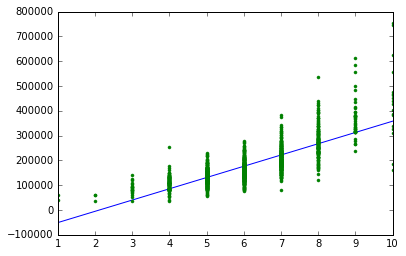

In [69]:
x = np.linspace(1,10,10)
print(x)
dfx = pd.DataFrame(data=x, columns=['OverallQual'])
print(dfx)
print(estimator.predict(dfx))
plt.plot(x, estimator.predict(dfx), '-')
plt.plot(train['OverallQual'], train['SalePrice'], '.')


In [71]:
train_OQ = pd.get_dummies(train[['OverallQual']], columns=['OverallQual'])
print(train_OQ)

      OverallQual_1.0  OverallQual_2.0  OverallQual_3.0  OverallQual_4.0  \
Id                                                                         
1                 0.0              0.0              0.0              0.0   
2                 0.0              0.0              0.0              0.0   
3                 0.0              0.0              0.0              0.0   
4                 0.0              0.0              0.0              0.0   
5                 0.0              0.0              0.0              0.0   
6                 0.0              0.0              0.0              0.0   
7                 0.0              0.0              0.0              0.0   
8                 0.0              0.0              0.0              0.0   
9                 0.0              0.0              0.0              0.0   
10                0.0              0.0              0.0              0.0   
11                0.0              0.0              0.0              0.0   
12          

Fit model using train_OC's OverallQual as a pretend categorical value with one-hot

In [76]:
# Leave one out as you need k-1 indicators for k total results (think of how you need one boolean indicator to represent two results)
features = train_OQ.columns[:-1]
print(features)
m = linear_model.LinearRegression(normalize=True) # Does normalize do anything here?
m.fit(train_OQ[features], train['SalePrice'])

Index(['OverallQual_1.0', 'OverallQual_2.0', 'OverallQual_3.0',
       'OverallQual_4.0', 'OverallQual_5.0', 'OverallQual_6.0',
       'OverallQual_7.0', 'OverallQual_8.0', 'OverallQual_9.0'],
      dtype='object')


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

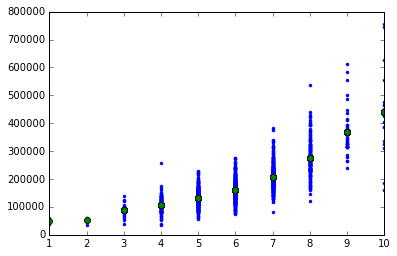

In [83]:
# This is overkill on the plotting.  I could just make a very simple identity matrix to plot all these predictions.
# ...but I'm lazy..
plt.plot(train['OverallQual'], train['SalePrice'], '.')
plt.plot(train['OverallQual'], m.predict(train_OQ[features]), 'o')

It actually predicts things!!! 

Looking at the coefficients...

In [89]:
print(m.intercept_)
list(zip(features, m.coef_))

438588.388889


[('OverallQual_1.0', -388438.38888888841),
 ('OverallQual_2.0', -386818.05555555609),
 ('OverallQual_3.0', -351114.63888888969),
 ('OverallQual_4.0', -330167.73371647543),
 ('OverallQual_5.0', -305065.04128183622),
 ('OverallQual_6.0', -276985.35412953066),
 ('OverallQual_7.0', -230871.965691397),
 ('OverallQual_8.0', -163852.8531746034),
 ('OverallQual_9.0', -71075.365633075184)]

They're all negative.  Whats up with that?  Wait, it is because I left the 10th out, which effectively becomes the intercept.  What if I did it the other way around?

Index(['OverallQual_2.0', 'OverallQual_3.0', 'OverallQual_4.0',
       'OverallQual_5.0', 'OverallQual_6.0', 'OverallQual_7.0',
       'OverallQual_8.0', 'OverallQual_9.0', 'OverallQual_10.0'],
      dtype='object')
50150.0


[('OverallQual_2.0', 1620.333333333559),
 ('OverallQual_3.0', 37323.750000000313),
 ('OverallQual_4.0', 58270.655172413833),
 ('OverallQual_5.0', 83373.347607052885),
 ('OverallQual_6.0', 111453.03475935823),
 ('OverallQual_7.0', 157566.42319749197),
 ('OverallQual_8.0', 224585.53571428548),
 ('OverallQual_9.0', 317363.02325581375),
 ('OverallQual_10.0', 388438.38888888864)]

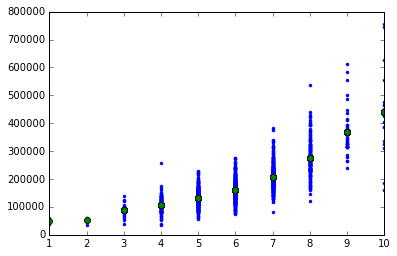

In [90]:
# Leave one out as you need k-1 indicators for k total results (think of how you need one boolean indicator to represent two results)
features = train_OQ.columns[1::]
print(features)
m = linear_model.LinearRegression(normalize=True) # Does normalize do anything here?
m.fit(train_OQ[features], train['SalePrice'])

# This is overkill on the plotting.  I could just make a very simple identity matrix to plot all these predictions.
# ...but I'm lazy..
plt.plot(train['OverallQual'], train['SalePrice'], '.')
plt.plot(train['OverallQual'], m.predict(train_OQ[features]), 'o')

print(m.intercept_)
list(zip(features, m.coef_))

Exactly!  Ok this makes sense.  So having a quality of say 8 adds $225000 to your house

## Next Steps
* Make a simple model with sqft + sale quality.  Submit to Kaggle.  Did it get better score than the old one?  Maybe use a few polynomials on sqft but dont go overboard?  Could always do linear+quality, then a few polys+qual, etc.
* Add a few extra categoricals to that same model.
* Expand to the entire set of categoricals and apply with RidgeCV.  How crazy does that get?  Does it give a better fit?
* Use the entire set of categoricals with LassoCV.  How good is that fit?
* Use LassoCV's selected features and then refit with RidgeCV.  Improvement on Lasso?
* Use the feature selection from scipy, does the feature set seem similar to Lasso?  Try Ridge with those features...  
* Were there other things I used in the sqft/simple model?

In [ ]:
train[nan_unintentional].empty()

In [ ]:
x = train[nan_unintentional].describe()

In [ ]:
x.loc['top']

In [ ]:
# Look down each column and replace missing values with the median of that column 
# (since we're using integers, median seemed to make more sense)
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp.fit(train[nan_unintentional])

In [ ]:
len(cols_non_numeric)
len(pd.isnull(train[cols_non_numeric]).any().nonzero()[0])

Convert these to dummy variables

In [ ]:
cols_non_numeric

In [ ]:
train['SalePrice'].value_counts()

In [ ]:
train[cols_non_numeric].count()

In [ ]:
pd.isnull(train[cols_non_numeric]).any().nonzero().columns()

In [ ]:
help(TransformerMixin)

In [ ]:
data = [
    [None, 2, 3],
    [10, None, 30],
]
df = pd.DataFrame(data)

In [ ]:
df

In [ ]:
df.replace(10, 'abc')

In [ ]:
pd.isnull(df)

In [ ]:
df.count()

In [ ]:
type(df[2][1])
